In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt
%matplotlib inline

In [2]:
trips = pd.read_csv("data/trip.csv")
weather = pd.read_csv("data/weather.csv")
stations = pd.read_csv("data/station.csv")
# status = pd.read_csv("status.csv")

In [3]:
stations.dtypes

id                     int64
name                  object
lat                  float64
long                 float64
dock_count             int64
city                  object
installation_date     object
dtype: object

In [4]:
trips.dtypes

id                     int64
duration               int64
start_date            object
start_station_name    object
start_station_id       int64
end_date              object
end_station_name      object
end_station_id         int64
bike_id                int64
subscription_type     object
zip_code              object
dtype: object

In [63]:
weather.dtypes

date                              datetime64[ns]
max_temperature_f                        float64
mean_temperature_f                       float64
min_temperature_f                        float64
max_dew_point_f                          float64
mean_dew_point_f                         float64
min_dew_point_f                          float64
max_humidity                             float64
mean_humidity                            float64
min_humidity                             float64
max_sea_level_pressure_inches            float64
mean_sea_level_pressure_inches           float64
min_sea_level_pressure_inches            float64
max_visibility_miles                     float64
mean_visibility_miles                    float64
min_visibility_miles                     float64
max_wind_Speed_mph                       float64
mean_wind_speed_mph                      float64
max_gust_speed_mph                       float64
precipitation_inches                     float64
cloud_cover         

In [6]:
# status.dtypes

In [7]:
# Cambio la columna 'installation_date', de stations, para que sea de tipo fecha.

stations.installation_date = pd.to_datetime(stations.installation_date, errors='coerce')

In [8]:
# Cambio 'start_date','end_date' a tipo fecha, y 'zip_code' a tipo numerico. Del dataframe trips

trips.start_date = pd.to_datetime(trips.start_date, errors='coerce')
trips.end_date = pd.to_datetime(trips.end_date, errors='coerce')
trips.zip_code = pd.to_numeric(trips.zip_code, errors='coerce')

In [98]:
# Cambio 'date' a tipo fecha y 'precipitation_inches' a numerico, de weather.

weather.date = pd.to_datetime(weather.date, errors='coerce')
weather.precipitation_inches = pd.to_numeric(weather.precipitation_inches, errors='coerce')

In [10]:
# Cambio 'time' de tipo fecha, de status

# status.time = pd.to_datetime(status.time, errors='coerce')

In [11]:
# Agrego una columna a trips para guardar fechas sin horas, para poder hacer operaciones entre dataframes.

trips['date'] = trips.start_date.dt.date
trips.date = pd.to_datetime(trips.date, errors='coerce')

In [12]:
# Las personas sin subscripciones hacen viajes mas largos.

trip_duration_subs = trips.loc[trips.subscription_type == 'Subscriber'].duration.mean()
trip_duration_nonsub = trips.loc[trips.subscription_type == 'Customer'].duration.mean()

print('Duracion de viajes promedio de personas con subscripcion: ' + str(trip_duration_subs))
print('Duracion de viajes promedio de personas sin subscripcion: ' + str(trip_duration_nonsub))

Duracion de viajes promedio de personas con subscripcion: 590.048856101
Duracion de viajes promedio de personas sin subscripcion: 3951.76132851


In [13]:
# Renombro duration a duration_sec, y agrego duration_min con la conversion a minutos.

trips.rename(columns={'duration' : 'duration_sec'}, inplace=True)
trips['duration_min'] = trips.duration_sec/60

In [14]:
# Cuánta gente se 'robó' bicicletas
# (Consideramos robada cuando tardó + de 1 semana en devolver)

diasDistintos = trips.loc[trips.start_date.dt.date != trips.end_date.dt.date, :]
unaSemana = 60 * 24 * 7
diasDistintos.loc[diasDistintos.duration_min > unaSemana, :].head(3)

,id,duration_sec,start_date,start_station_name,start_station_id,end_date,end_station_name,end_station_id,bike_id,subscription_type,zip_code,date,duration_min
80510,111309,722236,2013-11-30 13:29:00,University and Emerson,35,2013-12-08 22:06:00,University and Emerson,35,247,Customer,94301.0,2013-11-30,12037.266667
93400,129504,619322,2013-12-18 09:16:00,San Jose Diridon Caltrain Station,2,2013-12-25 13:18:00,SJSU 4th at San Carlos,12,653,Subscriber,94041.0,2013-12-18,10322.033333
195379,361321,715339,2014-07-13 05:50:00,Arena Green / SAP Center,14,2014-07-21 12:32:00,Adobe on Almaden,5,251,Customer,NaN,2014-07-13,11922.316667


In [15]:
# Merge de trips y weather

tw = pd.merge(trips, weather, on=['date', 'zip_code'], how='inner')

In [16]:
# Duracion segun 'cloud_cover'. Los dias nublados se viaja 

print "Promedio de duracion los dias nublados: ", tw.loc[tw.cloud_cover > 5, 'duration_min'].mean()
print "Promedio de duracion dias despejados: " ,tw.loc[tw.cloud_cover < 5, 'duration_min'].mean()

Promedio de duracion los dias nublados:  10.5936045463
Promedio de duracion dias despejados:  12.9198857326


In [17]:
# Duracion de los viajes segun el viento.

print "Promedio de duracion de los dias con poco viento: ", tw.loc[tw.mean_wind_speed_mph < 12, 'duration_min'].mean()
print "Promedio de duracion de los dias ventosos: ", tw.loc[tw.mean_wind_speed_mph > 12, 'duration_min'].mean()

Promedio de duracion de los dias con poco viento:  12.013626961
Promedio de duracion de los dias ventosos:  11.9448131887


In [18]:
# Viajes en los dias con temperatura encima del promedio, y debajo. Promedio de San Fransisco 57 F

print "Cantidad de viajes con clima de temperatura mayor a 59 F:", tw.loc[tw.mean_temperature_f > 59, :].size
print "Cantidad de viajes con clima de temperatura menor a 54 F:", tw.loc[tw.mean_temperature_f < 54, :].size
print "Promedio de duracion de los dias con temperatura mayor a 59 F: ", tw.loc[tw.mean_temperature_f > 59, 'duration_min'].mean()
print "Promedio de duracion de los dias con temperatura menor a 54 F: ", tw.loc[tw.mean_temperature_f < 54, 'duration_min'].mean()

Cantidad de viajes con clima de temperatura mayor a 59 F: 1848315
Cantidad de viajes con clima de temperatura menor a 54 F: 355320
Promedio de duracion de los dias con temperatura mayor a 59 F:  11.9890946619
Promedio de duracion de los dias con temperatura menor a 54 F:  13.9823269635


In [19]:
# Estaciones mas populares para el retiro de bicicletas

print "Top 10 estaciones para retirar bicicletas."
trips.groupby('start_station_name').size().sort_values(ascending=False).nlargest(n=10)

Top 10 estaciones para retirar bicicletas.


start_station_name
San Francisco Caltrain (Townsend at 4th)         49092
San Francisco Caltrain 2 (330 Townsend)          33742
Harry Bridges Plaza (Ferry Building)             32934
Embarcadero at Sansome                           27713
Temporary Transbay Terminal (Howard at Beale)    26089
2nd at Townsend                                  25837
Steuart at Market                                24838
Market at Sansome                                24172
Townsend at 7th                                  23724
Market at 10th                                   20272
dtype: int64

In [117]:
# Estaciones mas populares para la devolucion de bicicletas

print "Top 10 estaciones para devolver bicicletas." 
trips.groupby('end_station_name').size().nlargest(n=10)

Top 10 estaciones para devolver bicicletas.


end_station_name
San Francisco Caltrain (Townsend at 4th)         63179
San Francisco Caltrain 2 (330 Townsend)          35117
Harry Bridges Plaza (Ferry Building)             33193
Embarcadero at Sansome                           30796
2nd at Townsend                                  28529
Market at Sansome                                28033
Townsend at 7th                                  26637
Steuart at Market                                25025
Temporary Transbay Terminal (Howard at Beale)    23080
Market at 4th                                    19915
dtype: int64

In [21]:
# Cuales son las estaciones con mayor cantidad de muelles.

print "Estaciones con mayor cantidad de muelles: "


Estaciones con mayor cantidad de muelles: 


,id,name,lat,long,dock_count,city,installation_date
0,2,San Jose Diridon Caltrain Station,37.329732,-121.901782,27,San Jose,2013-08-06
65,77,Market at Sansome,37.789625,-122.400811,27,San Francisco,2013-08-25
49,61,2nd at Townsend,37.780526,-122.390288,27,San Francisco,2013-08-22
55,67,Market at 10th,37.776619,-122.417385,27,San Francisco,2013-08-23
15,22,Redwood City Caltrain Station,37.486078,-122.232089,25,Redwood City,2013-08-15
22,29,San Antonio Caltrain Station,37.406940,-122.106758,23,Mountain View,2013-08-15
39,50,Harry Bridges Plaza (Ferry Building),37.795392,-122.394203,23,San Francisco,2013-08-20
57,69,San Francisco Caltrain 2 (330 Townsend),37.776600,-122.395470,23,San Francisco,2013-08-23
43,55,Temporary Transbay Terminal (Howard at Beale),37.789756,-122.394643,23,San Francisco,2013-08-20
27,34,Palo Alto Caltrain Station,37.443988,-122.164759,23,Palo Alto,2013-08-14


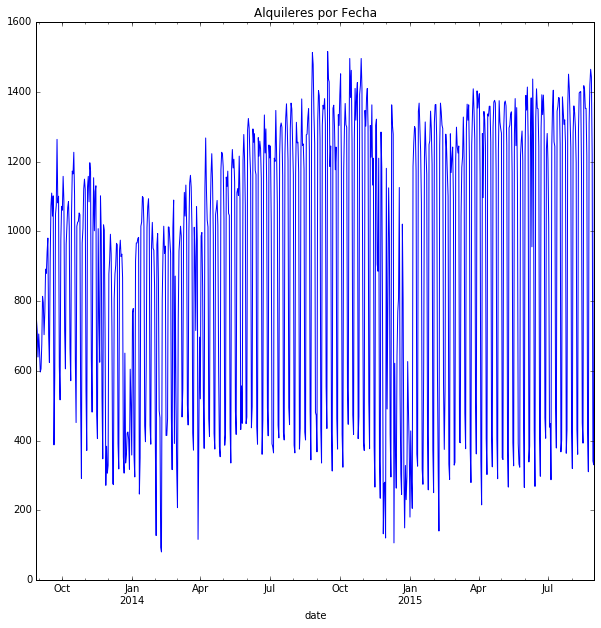

In [95]:
# Plot de alquileres por fecha.

trips.groupby('date').size().plot(figsize=(10,10), title='Alquileres por Fecha');

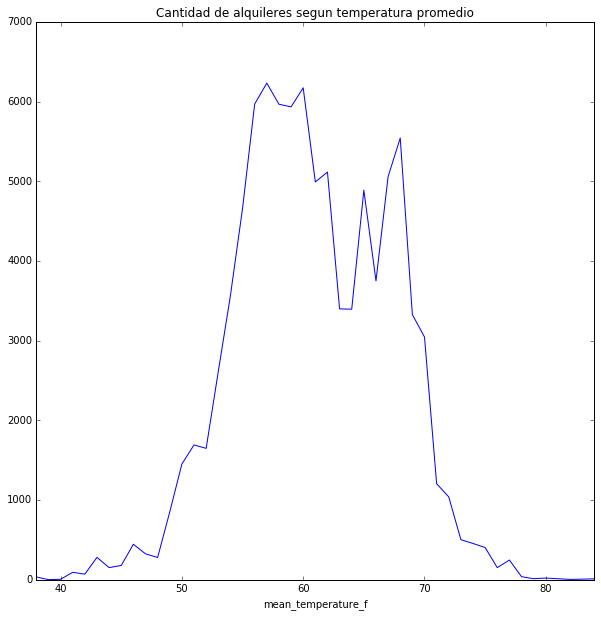

In [127]:
# Plot de alquileres por Temperatura

tw.groupby('mean_temperature_f').size().plot(figsize=(10,10), title='Cantidad de alquileres segun temperatura promedio');

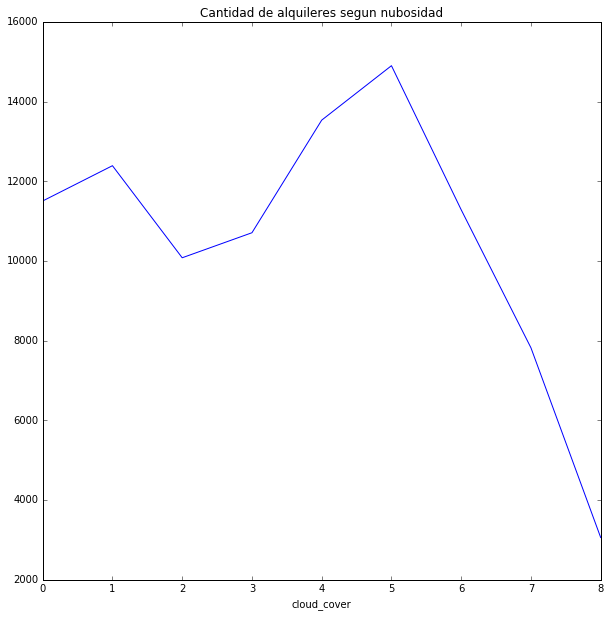

In [105]:
# Plot de alquileres por Nubosidad

tw.groupby('cloud_cover').size().plot(figsize=(10,10), title='Cantidad de alquileres segun nubosidad');

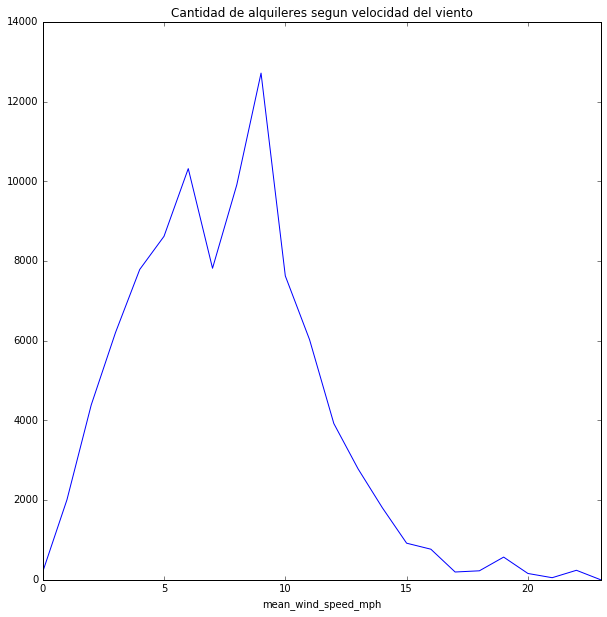

In [120]:
tw.groupby('mean_wind_speed_mph').size().plot(figsize=(10,10), title='Cantidad de alquileres segun velocidad del viento');